In [20]:
import elasticsearch
import git
import os
from git import Repo
import sys
from elasticsearch import Elasticsearch
print('ok')
def create_components(git_url,esurl,localdir):
    # if no url supplied for Elastic, assume the localhost
    if esurl =='':
        try:
            es = elasticsearch.Elasticsearch(['http://localhost:9200/'])
            #es = Elasticsearch(['http://localhost:9200/'])
            print('tried elastic')
            print(es.ping())
            #es = Elasticsearch()
        except:
            print('Elasticsearch not running at localhost:9200')
            sys.exit(1)
    else:
        try:
            es = elasticsearch.Elasticsearch([esurl])
        except:
            print('Elasticsearch not running at the given URL. For default localhost, do not provide the argument')
            sys.exit(1)
        
    # Get the default commit index name
    es_index_raw = str.split(git_url,'/')[-1].split('.')[0]+'_'+'index'
    # Get the default blame index name
    es_blame_index_raw = str.split(git_url,'/')[-1].split('.')[0]+'_'+'blame'+'_'+'index'
    es_index = es_index_raw.lower()
    es_blame_index = es_blame_index_raw.lower()
    print(es_index)
    print(es.ping())
    
    # Create elasticsearch instance
    
    # If local Repo path is not supplied, create default path in '/tmp'
    if localdir == '':
        if sys.platform == 'linux':
            local_dir ='/tmp/'+str.split(git_url,'/')[-1].split('.')[0]
        else:
            local_dir ='C:/Users/aveli/Downloads/'+str.split(git_url,'/')[-1].split('.')[0]
    else:
        local_dir = localdir
    # Check if the local Repo already exists
    if os.path.isdir(local_dir):
        # Load the local Repo
        try:
            print('well')
            repo = git.Repo(local_dir)   
        # Get the latest commit object in the local Repo
            local_commit = repo.commit()     
        except:
            print('No valid Repo found at the location. If unsure, remove the directory and try without local dir argument')
            sys.exit(1)
                       # latest local commit 
        
        # Get the latest commit object in the remote Repo
        remote = git.remote.Remote(repo, 'origin')      # remote repo
        info = remote.fetch()[0]                        # fetch changes
        remote_commit = info.commit  
        
        # If latest commit in local and remote differ refresh the local Repo
        if (local_commit.hexsha == remote_commit.hexsha ):
            print('No changes in the Repo...')
        else:    
            repo = git.Repo(local_dir) 
            o = repo.remotes.origin
            o.pull()
            # Analyse and store additional commit data
            store_commit_data(local_dir,es,es_index,es_blame_index,local_commit.hexsha,remote_commit.hexsha )
    else:
        # If no local Repo exists, clone the Repo
        try:
            if sys.platform == 'linux':
                git.Git('/tmp').clone(git_url)
            else:
                #os.makedirs(local_dir,0o777)
                git.Git('C:/Users/aveli/Downloads/').clone(git_url)
        except:
            print('Not able to clone the Repo. If there is a non Git directory with the  same name, delete it and then try')
            sys.exit(1)
        # Delete the elastic indices, if exist
        es.indices.delete(index=es_index, ignore=[400, 404])
        es.indices.delete(index=es_blame_index, ignore=[400, 404])
        # Create new elastic indices
        
        es.indices.create(es_index)
        es.indices.create(es_blame_index)
        # Call the function to store the necessary commit data
        print('store data')
        store_commit_data(local_dir,es,es_index,es_blame_index,'None','None')

    return es,es_index,es_blame_index

ok


In [21]:
import elasticsearch
from elasticsearch_dsl import Search,Q
import pandas as pd
import git
import re
from pydriller import RepositoryMining
from elasticsearch import helpers
from git import Repo
import os
def store_commit_data(local_dir,es,es_index,es_blame_index,local_commit,remote_commit):
    
    repo = Repo(local_dir)
    # Creating empty lists for carrying commit data
    doclist = []
    blamelist =[]
    # If the Repo has just been cloned, the program will traverse the whole Repo
    if(local_commit == 'None'):
        # using PyDriller's API.
        for commit in RepositoryMining(local_dir).traverse_commits():
               for mod in commit.modifications:
                    #Building Commit tuples
                    commit_data = {'hash':commit.hash,'Author':commit.author.name,'Email':commit.author.email,
                                       'message':commit.msg,'authored_date':commit.author_date,
                                       'Committer':commit.committer.name,'committed_date':commit.committer_date,
                                       'no._of_branches':len(commit.branches),'merge_commit?':commit.merge,
                                       'no._of_mod_files':len(commit.modifications),'dmm_unit_size':commit.dmm_unit_size,
                                       'dmm_unit_complexity':commit.dmm_unit_complexity,'dmm_unit_interfacing':commit.dmm_unit_interfacing,
                                       'file_name':mod.filename, 'file_path':mod.new_path, 'complexity': mod.complexity, 'functions': len(mod.methods),
                                       'lines_added':mod.added,'lines_removed': mod.removed,'loc':mod.nloc,'size': 0 if mod.source_code is None else len(mod.source_code.splitlines()),'tokens':mod.token_count
                                       
                                        }
                    # loading each commit tuple into the list
                    doclist.append(commit_data)
                    # Each modification object contains diff_parsed tag with "added" and "deleted" properties. 
                    alines = mod.diff_parsed['added']
                    # "added" property is a tuple list with line number and actual line text. List of text lines is extracted
                    addedlines = [x[1] if len(alines)>0 else 'None' for x in alines ]
                    
                    # Each modification object contains diff_parsed tag with "added" and "deleted" properties. 
                    blines = mod.diff_parsed['deleted']
                    # "deleted" property is a tuple list with line number and actual line text. List of text lines is extracted
                    deletedlines = [x[1] if len(blines)>0 else 'None' for x in blines]
                    count = 0
                    
                    # Absolute path of the file in the cloned repo. This is required to validate that the file has not been deleted in the subsequent commits
                    newfilepath = local_dir+'/'+str(mod.new_path)
                    # For bug fix commits, retrieving the blame data. Using Regex on Commit messages to identify bug fix commits
                    if len(re.findall(r"\bbug\b|\bBug\b|\bFix\b|\bfix\b",commit.msg))>0 and os.path.isfile(newfilepath):# & len(addedlines)>0:
                        # Running Git Blame on each added line.
                        for eachline in addedlines:
                            repo_blame = repo.blame(commit.hash,mod.new_path,eachline)
                            # Git Blame of a line can produce multiple records with each record representing a past modification
                            for blame_record in repo_blame:
                                # Git Blame produces duplicate records (Don't know why). Attempt to ignore duplicated by comparting the current record with the previous record
                                # Also Git Blame produces record of the same commit hash, which can be ignored
                                prev_record = ''
                                if str(commit.hash) !=str(blame_record[0]) and (str(blame_record[0]) != prev_record):
                                    # Building Blame tuple for each Blame record
                                    blame_doc = {'orig_hash':commit.hash,'blame_hash':str(blame_record[0]),
                                                    'file':mod.new_path}    
                                    # Loading blame data into the list
                                    blamelist.append(blame_doc)
                                    prev_record = blame_record[0]



    else:
        #if Repo has been refreshed, only delta commits are processed
        for commit in RepositoryMining(local_dir,from_commit = local_commit, to_commit = remote_commit ).traverse_commits():
            for mod in commit.modifications:
                    #Building Commit tuples
                    commit_data = {'hash':commit.hash,'Author':commit.author.name,'Email':commit.author.email,
                                       'message':commit.msg,'authored_date':commit.author_date,
                                       'Committer':commit.committer.name,'committed_date':commit.committer_date,
                                       'no._of_branches':len(commit.branches),'merge_commit?':commit.merge,
                                       'no._of_mod_files':len(commit.modifications),'dmm_unit_size':commit.dmm_unit_size,
                                       'dmm_unit_complexity':commit.dmm_unit_complexity,'dmm_unit_interfacing':commit.dmm_unit_interfacing,
                                       'file_name':mod.filename, 'file_path':mod.new_path, 'complexity': mod.complexity, 'functions': len(mod.methods),
                                       'lines_added':mod.added,'lines_removed': mod.removed,'loc':mod.nloc,'size': 0 if mod.source_code is None else len(mod.source_code.splitlines()),'tokens':mod.token_count
                                       
                                        }
                    # loading each commit tuple into the list
                    doclist.append(commit_data)
                    # Each modification object contains diff_parsed tag with "added" and "deleted" properties. 
                    alines = mod.diff_parsed['added']
                    # "added" property is a tuple list with line number and actual line text. List of text lines is extracted
                    addedlines = [x[1] if len(alines)>0 else 'None' for x in alines ]
                    
                    # Each modification object contains diff_parsed tag with "added" and "deleted" properties. 
                    blines = mod.diff_parsed['deleted']
                    # "deleted" property is a tuple list with line number and actual line text. List of text lines is extracted
                    deletedlines = [x[1] if len(blines)>0 else 'None' for x in blines]
                    count = 0
                    
                    # Absolute path of the file in the cloned repo. This is required to validate that the file has not been deleted in the subsequent commits
                    newfilepath = local_dir+'/'+str(mod.new_path)
                    # For bug fix commits, retrieving the blame data. Using Regex on Commit messages to identify bug fix commits
                    if len(re.findall(r"\bbug\b|\bBug\b|\bFix\b|\bfix\b",commit.msg))>0 and os.path.isfile(newfilepath):# & len(addedlines)>0:
                        # Running Git Blame on each added line.
                        for eachline in addedlines:
                            repo_blame = repo.blame(commit.hash,mod.new_path,eachline)
                            # Git Blame of a line can produce multiple records with each record representing a past modification
                            for blame_record in repo_blame:
                                # Git Blame produces duplicate records (Don't know why). Attempt to ignore duplicated by comparting the current record with the previous record
                                # Also Git Blame produces record of the same commit hash, which can be ignored
                                prev_record = ''
                                if str(commit.hash) !=str(blame_record[0]) and (str(blame_record[0]) != prev_record):
                                    # Building Blame tuple for each Blame record
                                    blame_doc = {'orig_hash':commit.hash,'blame_hash':str(blame_record[0]),
                                                    'file':mod.new_path}    
                                    # Loading blame data into the list
                                    blamelist.append(blame_doc)
                                    prev_record = blame_record[0]



    # using elasticsearch.py's helper tools to bulk load into elasticsearch's commit index           
    helpers.bulk(es,doclist,index=es_index,doc_type ='commit_data',request_timeout = 2000)
    # Since Git Blame produces duplicate data, getting only unique records
    blamelist_fil = [i for n, i in enumerate(blamelist) if i not in blamelist[n + 1:]]
    # using elasticsearch.py's helper tools to bulk load into elasticsearch's blame index
    helpers.bulk(es,blamelist_fil,index=es_blame_index,doc_type ='blame',request_timeout = 2000)
    # Very important to explicitly refresh the Elastic indices as they are not automatically done.
    es.indices.refresh([es_blame_index,es_index])

In [22]:
# Calling the base method to process and load the commit data. See "create_components" method for detail
p1 = create_components('https://github.com/R-Knowsys/elasticray.git','','')
#p2 = create_components('https://github.com/chaoss/grimoirelab.git','','')
#p3 = create_components('https://github.com/microsoft/vscode.git','','')
#p4 = create_components('https://github.com/tensorflow/tensorflow.git','','')    
#p5 = create_components('https://github.com/facebook/react-native.git','','')


tried elastic
True
elasticray_index
True
well
No changes in the Repo...


In [23]:
print(' ok again ')

 ok again 


In [24]:
import elasticsearch
from elasticsearch_dsl import Search,Q
import pandas as pd

def get_user_data(es_instance,commit_index,blame_index):
        # Assigning Elastic instance, Commit Elastic Index and Blame Elastic Index to variables
        es = es_instance
        es_ma_index = commit_index
        es_bl_index = blame_index
        # Using Elasticsearch DSL function to get the data of Commit index
        blame_es_data = Search(using=es, index=es_bl_index)
        # Loading data into a dictionary
        blame_dict = [hit.to_dict() for hit in blame_es_data.scan()]
        # Using Elasticsearch DSL function to get the data of Blame index
        commit_es_data = Search(using=es, index=es_ma_index)
        # Loading data into a dictionary
        commit_dict = [hit.to_dict() for hit in commit_es_data.scan()]
        # Creating pandas dataframe for commit data
        commit_frame = pd.DataFrame(commit_dict)
        # Creating pandas dataframe for blame data
        blame_frame = pd.DataFrame(blame_dict)
        # Getting the blame row count. If the frmae is empty, it means all the records are clean
        blame_count = blame_frame.shape[0]
        
        if blame_count>0:
            # Adding a column to Blame frame indicating that the row represents a Buggy commit
            blame_frame['type'] = 'Buggy'
            # Combining Commit frmae with Blame frame. An additional column called 'type' gets added to the Commit frame.
            comb_frame = pd.merge(commit_frame,blame_frame,how='left',left_on = ['hash','file_path'],right_on = ['blame_hash','file'])
        else:
            # If the Blame frame is empty, no need to merge.
            comb_frame=commit_frame
        # When merging happnes and 'type' column gets added to the main Commit frame, The rows that are not part of Blame frame are filled with 'Nan'.
        # Here, all the NaNs fro 'type' column are replaced with 'Clean' label.
        # Effectively, Each commit file (one Commit can contain more than one file) is categorised as either Buggy or Clean.
        comb_frame['type'] = comb_frame['type'].fillna('Clean')
        
        # Cleaning and retaining the required columns
        comb_frame_refined = comb_frame[['hash', 'Author','Committer', 'Email', 'message',                               'committed_date', 'no._of_branches', 'merge_commit?',
                                        'no._of_mod_files', 'dmm_unit_size', 'dmm_unit_complexity','dmm_unit_interfacing',
                                        'file_path', 'complexity','functions', 'lines_added', 'lines_removed', 'size', 'tokens',
                                        'type']]
        # Commit hash raw value is very long. Cutting the value into first ten chars 
        # Assumption is that the first ten chars rednder necessary uniqueness. May need to revisit later
        comb_frame_refined['hash'] = comb_frame_refined['hash'].str.slice(0,10)

        # Changing the type from string to Data. Used Pacific time zone. Heard the pacific coast is beautiful
        commit_frame['committed_date'] = commit_frame['committed_date'].astype('str').apply(lambda x: pd.to_datetime(x).tz_convert('US/Pacific'))
        
        # Sorting the frame by committes date
        comb_frame_refined = comb_frame_refined.sort_values('committed_date', ascending=False)
        
        #------ Attempting to score developers with a simple/simplistic calculation -----/
        
        # Replacing all NaN fields with zero
        comb_frame_refined = comb_frame_refined.fillna(0)
        # Adding commit count (actually commit file count) for each other column
        comb_frame_refined['commit_count'] = comb_frame_refined.groupby('Author').hash.transform('nunique')
        # Adding up three dmm values creating a new column
        comb_frame_refined['riskfreescore'] = comb_frame_refined['dmm_unit_size']+comb_frame_refined['dmm_unit_complexity']+comb_frame_refined['dmm_unit_interfacing']
        # Adding up "Lines Added" and "Lines Removed" and creating a new column
        comb_frame_refined['lineschanged'] = comb_frame_refined['lines_added']+comb_frame_refined['lines_removed']
        # Simple calculation to come up with a score for each row
        comb_frame_refined['score'] = comb_frame_refined.apply(lambda x:((x.riskfreescore)*10+(x.lineschanged)+(x.complexity)*10)/10,axis =1)
        # Filtering out the necessary columns and creating a new frame
        dev_score = comb_frame_refined[['Author','commit_count','score','type']]
        # Score is scaled based on the type of commit file
        dev_score['scaled_score'] = dev_score.apply(lambda x: x.score if x.type == 'Clean' else x.score/2,axis=1)
        # Retaining the necessary columns
        dev_score_refined = dev_score[['Author','commit_count','scaled_score']]
        # Calculating the Average score for the Author. A simple arithmetic mean.
        dev_score_refined['average_score'] = dev_score_refined.groupby('Author').scaled_score.transform('mean').round()
        dev_score_final = dev_score_refined[['Author','commit_count','average_score']].drop_duplicates().sort_values('average_score', ascending=False).reset_index().drop(columns = 'index') 
        return dev_score_final

In [25]:
import elasticsearch
from elasticsearch_dsl import Search,Q
import pandas as pd

def get_latest_commits(es_instance,commit_index,blame_index):
        # Assigning Elastic instance, Commit Elastic Index and Blame Elastic Index to variables
        es = es_instance
        es_ma_index = commit_index
        es_bl_index = blame_index
        # Using Elasticsearch DSL function to get the data of Commit index
        blame_es_data = Search(using=es, index=es_bl_index)
        # Loading data into a dictionary
        blame_dict = [hit.to_dict() for hit in blame_es_data.scan()]
        # Using Elasticsearch DSL function to get the data of Blame index
        commit_es_data = Search(using=es, index=es_ma_index)
        # Loading data into a dictionary
        commit_dict = [hit.to_dict() for hit in commit_es_data.scan()]
        # Creating pandas dataframe for commit data
        commit_frame = pd.DataFrame(commit_dict)
        # Creating pandas dataframe for blame data
        blame_frame = pd.DataFrame(blame_dict)
        # Getting the blame row count. If the frmae is empty, it means all the records are clean
        blame_count = blame_frame.shape[0]
        
        if blame_count>0:
            # Adding a column to Blame frame indicating that the row represents a Buggy commit
            blame_frame['type'] = 'Buggy'
            # Combining Commit frmae with Blame frame. An additional column called 'type' gets added to the Commit frame.
            comb_frame = pd.merge(commit_frame,blame_frame,how='left',left_on = ['hash','file_path'],right_on = ['blame_hash','file'])
        else:
            # If the Blame frame is empty, no need to merge.
            comb_frame=commit_frame
        # When merging happnes and 'type' column gets added to the main Commit frame, The rows that are not part of Blame frame are filled with 'Nan'.
        # Here, all the NaNs fro 'type' column are replaced with 'Clean' label.
        # Effectively, Each commit file (one Commit can contain more than one file) is categorised as either Buggy or Clean.
        comb_frame['type'] = comb_frame['type'].fillna('Clean')
        
        # Cleaning and retaining the required columns
        comb_frame_refined = comb_frame[['hash', 'Author','Committer', 'Email', 'message',                               'committed_date', 'no._of_branches', 'merge_commit?',
                                        'no._of_mod_files', 'dmm_unit_size', 'dmm_unit_complexity','dmm_unit_interfacing',
                                        'file_path', 'complexity','functions', 'lines_added', 'lines_removed', 'size', 'tokens',
                                        'type']]
        # Commit hash raw value is very long. Cutting the value into first ten chars 
        # Assumption is that the first ten chars rednder necessary uniqueness. May need to revisit later
        comb_frame_refined['hash'] = comb_frame_refined['hash'].str.slice(0,10)

        # Changing the type from string to Data. Used Pacific time zone. Heard the pacific coast is beautiful
        commit_frame['committed_date'] = commit_frame['committed_date'].astype('str').apply(lambda x: pd.to_datetime(x).tz_convert('US/Pacific'))
        # Sorting the frame by committes date
        comb_frame_refined = comb_frame_refined.sort_values('committed_date', ascending=False)
        
        return comb_frame_refined

In [26]:
get_latest_commits(p1[0],p1[1],p1[2])

c:\users\aveli\python37\lib\site-packages\ipykernel_launcher.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,hash,Author,Committer,Email,message,committed_date,no._of_branches,merge_commit?,no._of_mod_files,dmm_unit_size,dmm_unit_complexity,dmm_unit_interfacing,file_path,complexity,functions,lines_added,lines_removed,size,tokens,type
858,c8d7de8589,Abdon Pijpelink,Abdon Pijpelink,abdon.pijpelink@elastic.co,Upgrade to Elasticsearch 2.3.1,2016-04-14T16:04:40+02:00,1,False,10,0.500000,0.000000,0.000000,webs\elasticray-web\ivy.xml,NaN,0,3,2,13,NaN,Clean
857,c8d7de8589,Abdon Pijpelink,Abdon Pijpelink,abdon.pijpelink@elastic.co,Upgrade to Elasticsearch 2.3.1,2016-04-14T16:04:40+02:00,1,False,10,0.500000,0.000000,0.000000,webs\elasticray-web\docroot\WEB-INF\src\com\rk...,8.0,2,11,14,88,480.0,Clean
856,c8d7de8589,Abdon Pijpelink,Abdon Pijpelink,abdon.pijpelink@elastic.co,Upgrade to Elasticsearch 2.3.1,2016-04-14T16:04:40+02:00,1,False,10,0.500000,0.000000,0.000000,webs\elasticray-web\docroot\WEB-INF\src\com\rk...,12.0,6,18,18,109,495.0,Clean
855,c8d7de8589,Abdon Pijpelink,Abdon Pijpelink,abdon.pijpelink@elastic.co,Upgrade to Elasticsearch 2.3.1,2016-04-14T16:04:40+02:00,1,False,10,0.500000,0.000000,0.000000,webs\elasticray-web\docroot\WEB-INF\src\com\rk...,3.0,3,3,3,43,101.0,Clean
854,c8d7de8589,Abdon Pijpelink,Abdon Pijpelink,abdon.pijpelink@elastic.co,Upgrade to Elasticsearch 2.3.1,2016-04-14T16:04:40+02:00,1,False,10,0.500000,0.000000,0.000000,webs\elasticray-web\docroot\WEB-INF\src\com\rk...,15.0,3,23,18,148,889.0,Clean
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24,d8c0e1d460,Ajay Kottapally,Ajay Kottapally,ajay.k@rknowsys.com,Initial Commit,2014-06-25T18:06:14+05:18,1,False,35,0.429448,0.883436,0.911043,elastic-web\docroot\WEB-INF\lib\lucene-queries...,NaN,0,0,0,5503,NaN,Clean
23,d8c0e1d460,Ajay Kottapally,Ajay Kottapally,ajay.k@rknowsys.com,Initial Commit,2014-06-25T18:06:14+05:18,1,False,35,0.429448,0.883436,0.911043,elastic-web\docroot\WEB-INF\lib\lucene-misc.jar,NaN,0,0,0,2572,NaN,Clean
3,d8c0e1d460,Ajay Kottapally,Ajay Kottapally,ajay.k@rknowsys.com,Initial Commit,2014-06-25T18:06:14+05:18,1,False,35,0.429448,0.883436,0.911043,elastic-web\.classpath,NaN,0,46,0,46,NaN,Clean
1,7399a759b7,K. C. Ramakrishna,K. C. Ramakrishna,kcr@rknowsys.com,Initial commit,2014-06-17T20:23:00+05:18,1,False,2,NaN,NaN,NaN,README.md,NaN,0,4,0,4,NaN,Clean


In [27]:
# Processing data for few Git Repos. Look into the above method definitions for detail
#p1 = create_components('https://github.com/R-Knowsys/elasticray.git','','')
p2 = create_components('https://github.com/chaoss/grimoirelab.git','','')
#p3 = create_components('https://github.com/microsoft/vscode.git','','')
#p4 = create_components('https://github.com/tensorflow/tensorflow.git','','')    
#p5 = create_components('https://github.com/facebook/react-native.git','','')
print('created')
# Getting the commit data as pandas frames
#p1_commits = get_latest_commits(p1[0],p1[1],p1[2])
p2_commits = get_latest_commits(p2[0],p2[1],p2[2])
#p4_commits = get_latest_commits(p4[0],p4[1],p4[2])

# Combining commit data from two Git Repos. Add as many Repos as you like
#total_commits = p2_commits.append(p4_commits)
total_commits = p2_commits
print(total_commits.shape)

tried elastic
True
grimoirelab_index
True
well
No changes in the Repo...
created


c:\users\aveli\python37\lib\site-packages\ipykernel_launcher.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


(1889, 20)


In [28]:
# Preprocessing the data. ML requires the data to be converted to numericals
ml_commits = total_commits[['Author', 'no._of_mod_files', 'dmm_unit_size',
       'dmm_unit_complexity', 'dmm_unit_interfacing', 'complexity', 'functions', 'lines_added', 'lines_removed', 
       'tokens', 'type']]
# Assign 15 to Clean row and 5 to buggy row
ml_commits['type'] = ml_commits['type'].apply(lambda x:15 if x=='Clean' else 5)
# Resetting the frame's index. It is required to retain the integrity of the frame
ml_commits = ml_commits.reset_index().drop(columns = 'index')
# Author column needs to be dropped before converting the all the fields into numeric types
ml_commits_na = ml_commits.drop(columns = ['Author'])
# Converting the fields to numeric types, filling the NaNs with zeros
ml_commits_numeric =ml_commits_na.apply(pd.to_numeric,errors ='coerce').fillna(0)
# Adding teh Author column back
ml_commits_numeric['Author']=ml_commits['Author']
ml_commits_numeric_na = ml_commits_numeric.drop(columns=['Author'])
print('shapes')
print(ml_commits_numeric.shape)
print(ml_commits_numeric_na.shape)

shapes
(1889, 11)
(1889, 10)


c:\users\aveli\python37\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [29]:
# Attempt to remove outliers. May not be required
from scipy import stats
import numpy as np

#df = ml_commits_numeric
#df1 = df[(np.abs(stats.zscore(df)) < 3).all(axis=1)]
ml_commits_nout = ml_commits_numeric[(np.abs(stats.zscore(ml_commits_numeric.select_dtypes(exclude='object'))) < 3).all(axis=1)]
ml_commits_mode = ml_commits_nout.select_dtypes(exclude='object').mode()
ml_commits_out = ml_commits_numeric[~(np.abs(stats.zscore(ml_commits_numeric.select_dtypes(exclude='object'))) < 3).all(axis=1)]
#print(ml_commits_nout.shape)
#print(ml_commits_numeric.shape)
index = 0
'''
while index<ml_commits_mode.size-1:
    
    ml_commits_out.iloc[:,index] = ml_commits_mode.iloc[0,index]
    index +=1
'''
#df3.iloc[:,0] = df2.iloc[0,0]
ml_commits_all = ml_commits_nout.append(ml_commits_out).reset_index()
ml_commits_fil = ml_commits_all[['Author','complexity','lines_added','type']]

ml_commits_all_na = ml_commits_all.drop(columns = ['Author'])
ml_commits_fil_na = ml_commits_fil.drop(columns = ['Author'])
print('outlier shapes')
print(ml_commits_all_na.shape)
print(ml_commits_all.shape)
ml_commits_all.columns

outlier shapes
(1889, 11)
(1889, 12)


Index(['index', 'no._of_mod_files', 'dmm_unit_size', 'dmm_unit_complexity',
       'dmm_unit_interfacing', 'complexity', 'functions', 'lines_added',
       'lines_removed', 'tokens', 'type', 'Author'],
      dtype='object')

In [30]:
# Dimentionality Reduction before training with Kmeans.
# Dimentionality Reduction is the technique used to identify the most influential features for machine learning
# The input data in this case contains just ten features. Hence, this may not be required
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Normalizer
from sklearn.decomposition import PCA

# Assigning the input frame to a simpler variable
df = ml_commits_numeric_na
# Creating the instance of Standard Scaler
scaler = StandardScaler()
# Transforming the input data using Standard Scaler
data_scaled = scaler.fit_transform(df)
# Creating the instance of PCA. PCA is a popular tool for the purpose of Dimentionality Reduction
pca = PCA()
# Processing the scaled data using PCA
pca.fit(data_scaled)
# Printing the variance ratio for each feature. FYI, each column of the frame represents a feature
pca.explained_variance_ratio_

array([3.40442980e-01, 2.55681719e-01, 1.30478981e-01, 1.01217328e-01,
       8.95690441e-02, 6.60195337e-02, 1.06180310e-02, 4.59817348e-03,
       1.31372830e-03, 6.04819766e-05])

Text(0, 0.5, 'Cumulatve Explained Variance')

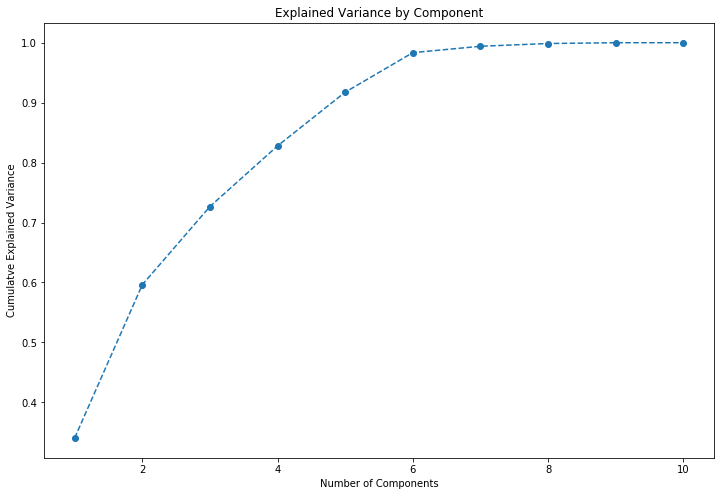

In [31]:
#Plotting the variance ratios for each feature
import matplotlib.pyplot as plt
plt.figure(figsize = (12,8))
plt.plot(range(1,11),pca.explained_variance_ratio_.cumsum(),marker = 'o',linestyle = '--')
plt.title('Explained Variance by Component')
plt.xlabel('Number of Components')
plt.ylabel('Cumulatve Explained Variance')

In [32]:
# From the above plot, it is clear that first three features have major impact on variance. And the last five have no imapct at all.
# Hence, we can try Kmeans with first three features
pca = PCA(n_components = 3)
pca.fit(data_scaled)
scores_pca = pca.transform(data_scaled)
print(scores_pca.shape)

(1889, 3)


Text(0, 0.5, 'Inertia')

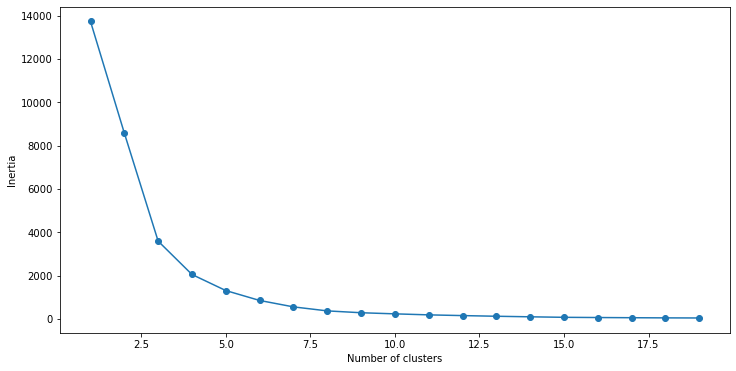

In [33]:
# Inertia calculation provides insights into required number of Clusters

SSE = []

for cluster in range(1,20):
    kmeans_pca = KMeans(n_clusters = cluster, init='k-means++',random_state = 42)
    kmeans_pca.fit(scores_pca)
    SSE.append(kmeans_pca.inertia_)

    # converting the results into a dataframe and plotting them
frame = pd.DataFrame({'Cluster':range(1,20), 'SSE':SSE})
plt.figure(figsize=(12,6))
plt.plot(frame['Cluster'], frame['SSE'], marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')

In [34]:
from sklearn.mixture import GaussianMixture
gmm = GaussianMixture(n_components=5,random_state=42).fit(scores_pca)
# cluster label for each data point
labels = gmm.predict(scores_pca)
print(labels[1:60])
# probability of each data point belonging to different clusters
memberprobs = gmm.predict_proba(scores_pca)
print(memberprobs[1:60,])

[0 0 4 0 0 4 4 1 4 4 4 4 1 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 1 4 4 4 4 4
 4 4 1 4 4 4 4 4 4 0 4 0 0 0 0 1 1 0 0 0 0 0]
[[9.99317885e-001 2.16286941e-008 0.00000000e+000 1.03990493e-293
  6.82093421e-004]
 [9.99719915e-001 8.09212735e-009 0.00000000e+000 1.27084990e-286
  2.80076743e-004]
 [1.78948541e-003 3.23470180e-005 0.00000000e+000 3.37400196e-317
  9.98178168e-001]
 [9.99633256e-001 8.56702684e-009 0.00000000e+000 3.72816751e-276
  3.66735682e-004]
 [9.99633256e-001 8.56702684e-009 0.00000000e+000 3.72816751e-276
  3.66735682e-004]
 [0.00000000e+000 1.14346091e-004 0.00000000e+000 0.00000000e+000
  9.99885654e-001]
 [0.00000000e+000 1.15212687e-004 0.00000000e+000 0.00000000e+000
  9.99884787e-001]
 [0.00000000e+000 1.00000000e+000 0.00000000e+000 0.00000000e+000
  0.00000000e+000]
 [0.00000000e+000 4.53370279e-004 0.00000000e+000 0.00000000e+000
  9.99546630e-001]
 [0.00000000e+000 4.53370279e-004 0.00000000e+000 0.00000000e+000
  9.99546630e-001]
 [0.00000000e+000 4.66520656e

In [35]:

# Using data_scaled. This can be replaced with data_normalized or scores_pca
mix = GaussianMixture(n_components=5,random_state=42)
s = mix.fit(scores_pca)
# Converting the input data series into pandas Dataframe
cluster_frame = pd.DataFrame(scores_pca)
# Adding Author column to the frame. Since the frame indices match, we can use the base input columns
cluster_frame['Author'] = ml_commits_numeric['Author']
# Calculating mean of each column values grouped by the Author
#clust_auth_frame = cluster_frame.groupby(['Author'],as_index=True)#.reset_index()#.drop(columns = 'index')
clust_auth_frame = cluster_frame.groupby(['Author'],as_index=True).mean()

#print(clust_auth_frame)
# predicting the cluster for each author. Keep in mind that the above step creates Authors as index of the input frame
auth_pred_scores = mix.predict(clust_auth_frame)

# Adding the predicted cluster as a column
#clust_auth_frame['cluster'] = auth_pred_scores

#clust_auth_frame[['cluster']]
clust_auth_frame['cluster'] = auth_pred_scores

clust_auth_frame[['cluster']]

,cluster
Author,
Alberto Martín,0
Alvaro del Castillo,1
Animesh Kumar,0
Benjamin Copeland,0
Brent Beer,1
David Moreno,1
David Moreno Lumbreras,1
Drashti,3
Elexy,1
